# Explainable reasoning with ChiRho (categorical variables)

The **Explainable Reasoning with ChiRho** package aims to provide a systematic, unified approach to causal explanation computations in terms of different probabilistic queries over expanded causal models that are constructed from a single generic program transformation applied to an arbitrary causal model represented as a ChiRho program. The approach of reducing causal queries to probabilistic computations on transformed causal models is the foundational idea behind all of ChiRho. The key strategy underlying "causal explanation" queries is their use of auxiliary variables representing uncertainty about what the proposed interventions are and which interventions or preemptions to apply, implicitly inducing a search space over counterfactuals.

The goal of this notebook is to illustrate how the package can be used to provide an approximate method of answering a range of causal explanation queries with respect to models in which categorical variables play the key role. As the key tool will involve sampling-based posterior probability estimation, a lot of what will be said *mutatis mutandis* applies to more general settings where variables are continuous (to which we will devote another tutorial).

In yet [another notebook](https://basisresearch.github.io/chirho/actual_causality.html) we illustrate how the module allows for a faithful reconstruction of a particular notion of local explanation (the so-called Halpern-Pearl modified definition of actual causality [(J. Halpern, MIT Press, 2016)](https://mitpress.mit.edu/9780262537131/actual-causality/)), which inspired some of the conceptual steps underlying the current implementation.

**Outline**

[Introduction and motivations](#introduction-and-motivations)

- [Causal explanation and counterfactual thinking](#causal-explanation-and-counterfactual-thinking)     

- [The but for condition](#the-but-for-condtition)

[Witness nodes and context sensitivity](#witness-nodes-and-context-sensitivity)

[Probability of causation and responsibility](#probability-of-causation-and-responsibility)

## Introduction and motivations

### Causal explanation and counterfactual thinking

Consider the following causality-related queries:

- **Friendly Fire:** On March 24, 2002, A B-52 bomber fired a Joint Direct Attack Munition at a US battalion command post, killing three and injuring twenty special forces soldiers. Out of multiple potential contributing factors, which were actually responsible for the incident?

- **Overshoot:** In dealing with an epidemic, multiple different policies were imposed, leading to the overshoot (the number of those who became infected after the peak of the epidemic) rising from around 15% in the unintervened model to around 25%. Which of the policies caused the overshoot and to what extent?

- **Explainable AI:** Your pre-trial release has been refused based on your [COMPAS score](https://en.wikipedia.org/wiki/COMPAS_(software)). The decision was made using a proprietary predictive model. All you have access to is the questionnaire that was used, and perhaps some demographic information about a class of human beings subjected to this evaluation. But which of these factors resulted in your score being what it is, and what were their contributions?


Questions of this sort are more local than those pertaining to average treatment effects, as they pertain to actual cases that come with their own contexts. Being able to answer them is useful for understanding how we can prevent undesirable outcomes similar to ones that we have observed, or promote the occurrence of desirable outcomes in contexts similar to the ones in which they had been observed. These context-sensitive causality questions are also an essential element of blame and responsibility assignments. If the phenomenon we're trying to explain is the behavior of a predictive model, we are dealing with a problem in explainable AI; but the underlying intuition behind the workings of **Explainable Reasoning with ChiRho** is that causally explaining the behavior of an opaque model is not that much different from providing a causal explanation of other real-world phenomena: we need to address such queries in a principled manner employing some approximate but hopefully reliable causal model of how things work (be that events outside of computers, or a predicitive model's behavior). **Explainable Reasoning with ChiRho** package aims to provide a unified general approach to the relevant causal explanation computations.

At some level of generality, a useful point of departure is a general counterfactual one. On one hand, we can ask about the **probability of necessity** (would the event occurred had a given candidate cause not taken place?) and about the **probability of sufficiency** (in line with the ideas present in Pearl's *Probabilities of causation...* and Chapter 9 of Pearl's *Causality*). We will start there, but soon we will notice that often our explanatory questions are more local, and the general intuition (inspired by Halpern's *Actual Causality*) that we implemented is that when we ask local explanatory questions, we need to keep some part of the context fixed and consider alternative scenarios insofar as potential causes are involved. That is, we (i) search through possible alternative interventions that could be performed on the candidate cause nodes, (ii) search through possible context nodes that are to be intervened to be at their factual values even in the counterfactual worlds, (iii) see how these options play out in intervened worlds, and (iv) investigate and meaningfully summarize what happens with the outcome nodes of interest in all those counterfactual worlds. 

In [1]:
%env CUDA_VISIBLE_DEVICES=-1

import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import seaborn as sns
import torch
from chirho.counterfactual.handlers.counterfactual import MultiWorldCounterfactual
from chirho.explainable.handlers import SearchForNS
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.observational.handlers import condition

env: CUDA_VISIBLE_DEVICES=-1


Let's start with a very simple model, in which a forest fire can be caused by exactly one of two things: a match being dropped (`match_dropped`), or a lightning strike (`lightning`), and either of these factors alone is already deterministically sufficient for the `forest_fire` to occur. A match being dropped is more likely than a lightning strike (we use fairly large probabilities for the sake of example transparency). For the sake of illustration, we also include a causally irrelevant site representing whether a ChiRho developer smiles, `smile`.

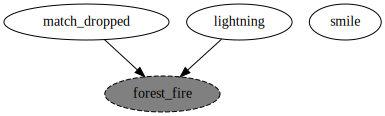

In [2]:
def ff_disjunctive():
    match_dropped = pyro.sample(
        "match_dropped", dist.Bernoulli(0.7)
    )  # notice uneven probs here
    lightning = pyro.sample("lightning", dist.Bernoulli(0.4))

    # this is a causally irrelevant site
    pyro.sample("smile", dist.Bernoulli(0.5))

    forest_fire = pyro.deterministic(
        "forest_fire", torch.max(match_dropped, lightning), event_dim=0
    )

    return {
        "match_dropped": match_dropped,
        "lightning": lightning,
        "forest_fire": forest_fire,
    }


pyro.render_model(ff_disjunctive)

One might be interested in using the model to answer **a range of causal-explanation related questions**.

- Did the dropped match actually cause the fire?
- Suppose you only know that the forest fire occurred, what are the likely explanations? How likely are they?
- Suppose you know both factors occurred, to what extent should they be deemed responsible for this outcome?

Let's see how these can be addressed using ChiRho. 

Throughout this tutorial we assume all nodes are binary and use $'$ as negation, i.e. we assume 
$x' = 1-x$. Our point of departure is the three probabilities of causation discussed by Pearl. Let's start with the least local one. $PNS := P(y_{x},y'_{x'})$ is the probability of necessity and sufficiency, the joint of probability that $Y=y$ under the intervention $do(X=x)$ and that $Y=y'$ under the intervention $do(X=x')$. Intuitively, the latter corresponds to sufficiency and the former to necessity. we can estimate this quantity as follows.

In [3]:
# Estimating PNS of dropping a match on a forest fire

antecedents = {"match_dropped": torch.tensor(0.0)}  # this is or x'
consequents = {"forest_fire": constraints.boolean}
observations = {
    "match_dropped": torch.tensor(1.0)
}  # this is our x, we ensure the sufficiency intervention (which copies the factual value) will be 1


with MultiWorldCounterfactual() as ffd_ns_mwc:  # needed to keep track of multiple scenarios
    with SearchForNS(
        antecedents=antecedents,
        antecedent_bias=-0.5,
        # the above sets the antecedent preemption probability to 0
        # and forces antecedent interventions in counterfactual worlds
        witnesses={},  # these are context nodes, we will get back to them later
        consequents=consequents,
    ):
        with condition(data=observations):
            with pyro.plate("sample", size=1000):
                with pyro.poutine.trace() as ffd_ns_tr:
                    ff_disjunctive()


ffd_ns_tr.trace.compute_log_prob()
ffd_ns_nd = ffd_ns_tr.trace.nodes

The above executes the model in parallel in three different worlds. Unmodified (world 0), with the necessity intervention (intervening with $X=x'$, world 1), and a sufficiency intervention, intervening on $X$ to have the observed value (in our case, $x$). We can plot the posterior samples for the outcome variable from worlds 1 and 2 separately.

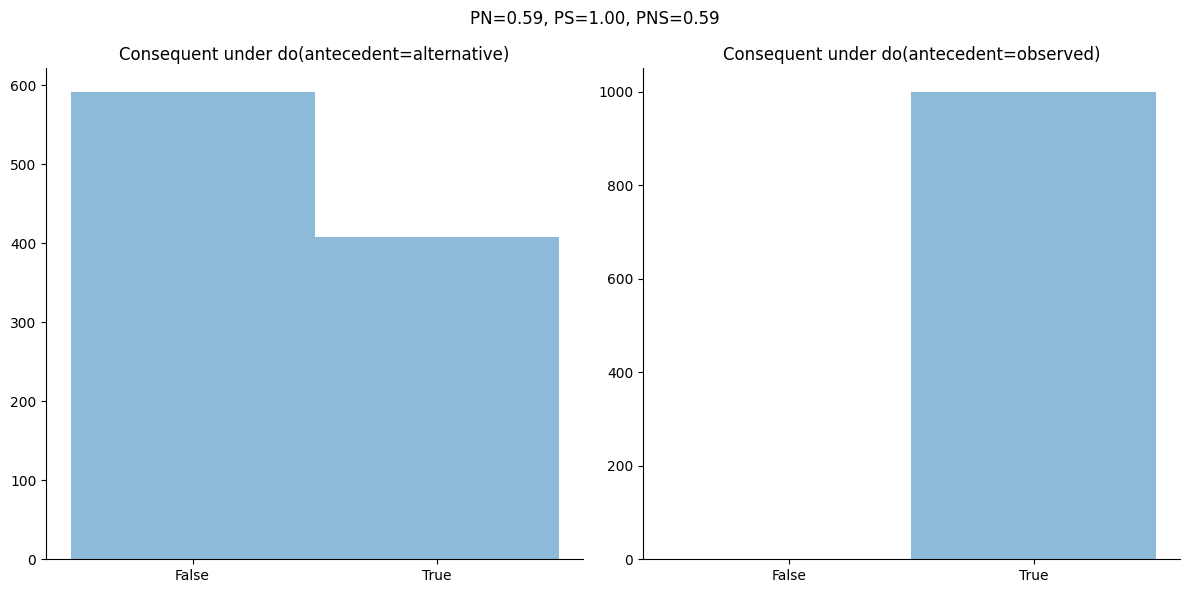

In [4]:
def pns_plot(
    mwc, nodes, antecedent_sites, outcome_site, plot_sufficiency=True, mask=None
):

    index_sets = [IndexSet(**{a: {n} for a in antecedent_sites}) for n in range(3)]
    with mwc:
        necessity = gather(nodes[outcome_site]["value"], index_sets[1]).flatten()
        sufficiency = gather(nodes[outcome_site]["value"], index_sets[2]).flatten()

    if mask is not None:
        necessity = necessity[mask]
        sufficiency = sufficiency[mask]

    nec_and_suff = (1 - necessity) * sufficiency

    pr_nec = torch.mean(1 - necessity)
    pr_suff = torch.mean(sufficiency)
    pr_nec_and_suff = torch.mean(nec_and_suff)

    if plot_sufficiency:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        ax1.hist(necessity, bins=[-0.5, 0.5, 1.5], alpha=0.5)
        ax1.set_title("Consequent under do(antecedent=alternative)")
        ax1.set_xticks([0, 1])
        ax1.set_xticklabels(["False", "True"])

        ax2.hist(sufficiency, bins=[-0.5, 0.5, 1.5], alpha=0.5)
        ax2.set_title("Consequent under do(antecedent=observed)")
        ax2.set_xticks([0, 1])
        ax2.set_xticklabels(["False", "True"])

        fig.suptitle(f"PN={pr_nec:.2f}, PS={pr_suff:.2f}, PNS={pr_nec_and_suff:.2f}")
        sns.despine()
        plt.tight_layout()
        plt.show()

    else:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.hist(necessity, bins=[-0.5, 0.5, 1.5], alpha=0.5)
        ax.set_title("Consequent under do(antecedent=alternative)")
        ax.set_xticks([0, 1])
        ax.set_xticklabels(["False", "True"])

        fig.suptitle(f"PN={pr_nec:.2f}")
        sns.despine()
        plt.tight_layout()
        plt.show()


pns_plot(
    mwc=ffd_ns_mwc,
    nodes=ffd_ns_nd,
    antecedent_sites=["match_dropped"],
    outcome_site="forest_fire",
)

On the visualizations, by $PN$ we mark (1 - the posterior mean from world 1) and by $PS$ we mark the posterior mean from world $2$ (this somewhat departs from what we will explicitly define the quantities to be, but we hope this will cause no ambiguity). Notice how the match being dropped isn't fully necessary for the fire as in approximately 40% of the cases the fire would've been caused by the lightning anyway. As in our model, unrealistically, dropping a match is bound to cause a fire, the probability of sufficiency is 1, and so unsurprisingly $PNS$ is the same as the probability of necessity. 

Two somewhat more local probabilities of causation discussed by Pearl are the probability of necessity:
$PN:= P(y'_{x'}\vert x, y)$ and the probability of sufficiency, $PS:=P(y_{x}\vert x', y')$. To estimate these more local quantities, we need to exercise some caution and use the handler in two different runs conditioning on two different observation sets, as otherwise instead of $PS$ we would be estimating $P(y_{x}\vert x,y)$ which is not a very useful quantity, as we illustrate using `smile` as a potential cause of the forest fire.

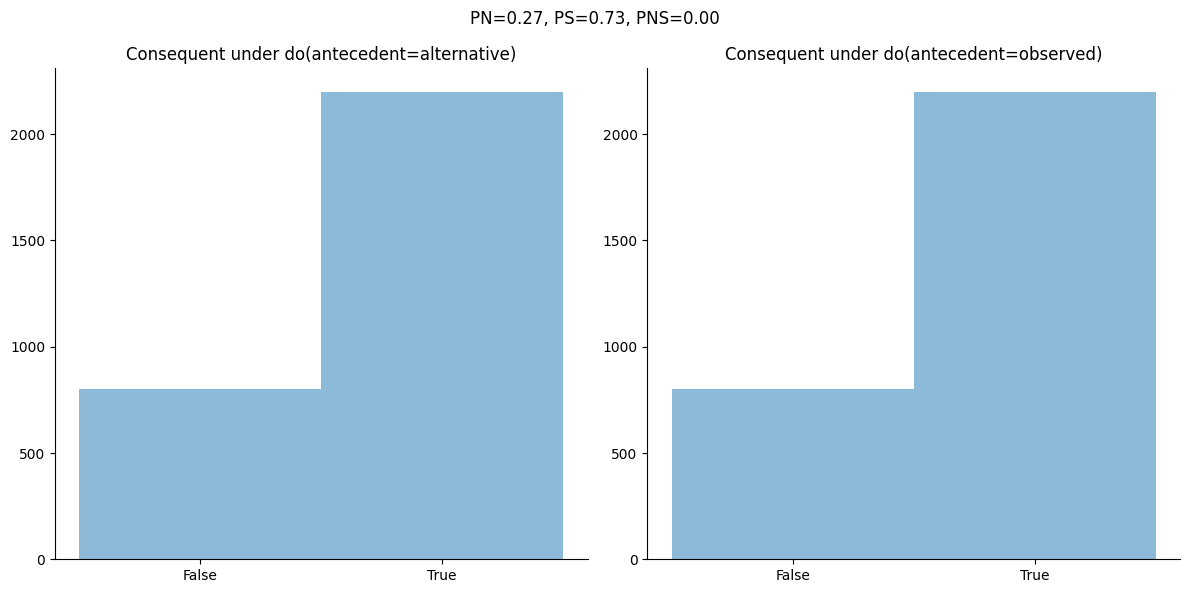

In [5]:
observations = {"smile": torch.tensor(1.0), "forest_fire": torch.tensor(1.0)}

with MultiWorldCounterfactual() as ff_condition_1_ns_mwc:  # needed to keep track of multiple scenarios
    with SearchForNS(
        antecedents=antecedents,
        antecedent_bias=-0.5,  # this forces antecedent interventions in counterfactual worlds
        witnesses={},
        consequents=consequents,
    ):
        with condition(data=observations):
            with pyro.plate("sample", size=1000):
                with pyro.poutine.trace() as ff_condition_1_ns_tr:
                    ff_disjunctive()


ff_condition_1_ns_tr.trace.compute_log_prob()
ff_condition_ns_nd = ff_condition_1_ns_tr.trace.nodes

pns_plot(
    mwc=ff_condition_1_ns_mwc,
    nodes=ff_condition_ns_nd,
    antecedent_sites=["smile"],
    outcome_site="forest_fire",
)

In the above run, PN is estimated correctly to be 0. On the other hand, since forest fire occurs in the observed world and smiling makes no difference, the expected value of `forest_fire` in the sufficiency-intervened world is the same as in the factual one, which is misleading. PNS comes out having the correct value, but this is only because PN is correctly estimated to be 0. Instead, to correctly estimate PS we need to change the observations we condition on, as follows. We somewhat depart from Pearl by setting the antecedent to 1 in the observed world, but this only to have the sufficiency intervention the right value to copy, downstream effects of `smile = 1` are replaced by those of `smile = 0` in world 2. Given that the only way a forest fire can fail to occur is if `match_dropped` and `lightning` are both 0, which is something we could deterministically infer from the observations.

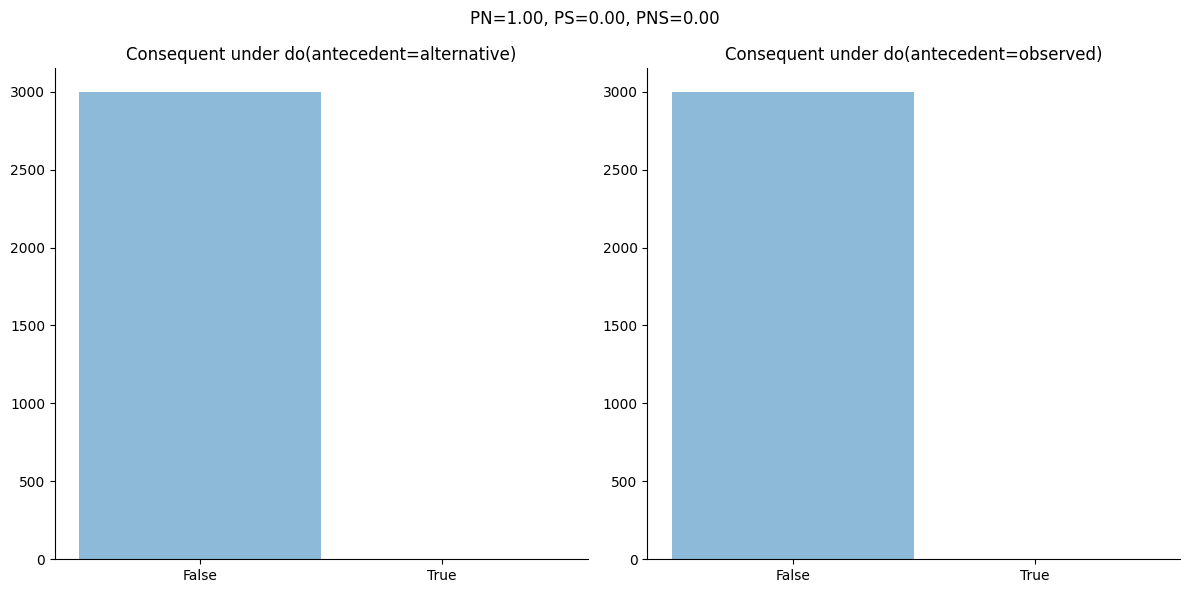

In [6]:
observations = {
    "smile": torch.tensor(1.0),
    "forest_fire": torch.tensor(0.0),
    "match_dropped": torch.tensor(0.0),
    "lightning": torch.tensor(0.0),
}
# changed the outcome, added deductive consequences of the observed consequent

with MultiWorldCounterfactual() as ff_condition_2_ns_mwc:
    with SearchForNS(
        antecedents=antecedents,
        antecedent_bias=-0.5,
        witnesses={},
        consequents=consequents,
    ):
        with condition(data=observations):
            with pyro.plate("sample", size=1000):
                with pyro.poutine.trace() as ff_condition_2_ns_tr:
                    ff_disjunctive()


ff_condition_2_ns_tr.trace.compute_log_prob()
ff_condition_2_ns_nd = ff_condition_2_ns_tr.trace.nodes

pns_plot(
    mwc=ff_condition_2_ns_mwc,
    nodes=ff_condition_2_ns_nd,
    antecedent_sites=["smile"],
    outcome_site="forest_fire",
)

In the above run in world 2 the expected value of forest fire is 0, which is the correct estimation of the probability of sufficiency for `smile` (notice that now the estimation of PN is off). So, while looking at estimates of PN and PS at the same time is correct if we do not condition, it's best to inspect these separately as resulting from different conditionings. 

### The but for condition

In what follows let's focus on the probability of necessity , although symmetrically, what we have to say will apply to sufficiency as well. Testing whether the outcome wouldn't have happened but for the antecedent node having the observed value, also called  the *but-for test*, has a tradition of being used as a tool for answering causality and attribution queries. 

- It is often used in [the law of torts](https://plato.stanford.edu/entries/causation-law/) to determine if a defendant's conduct was the cause of a particular harm. The test is often formulated as follows: "But for the defendant's conduct, would the harm have occurred?" 
- A major philosophical position in the analysis of causality is that the definition of causal dependence should be formulated in terms of counterfactual conditionals (Lewis, 1973. “Causation”, Journal of Philosophy, 70: 556–67). On this approach, $e$ causally depends on $c$ if and only if, if $c$ were not to occur $e$ would not occur. (The view does not remain uncontested, see the [SEP entry on counterfactual theories of causation](https://plato.stanford.edu/entries/causation-counterfactual/)).
- At least a few major approaches to explainable AI (such as [LIME](https://arxiv.org/abs/1602.04938),  or [Shapley values](https://papers.nips.cc/paper_files/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html))  are based on the idea that explanations can be obtained by perturbing or shifting the input values and observing the changes in the output. This to a large extent can be thought of as a way of evaluating the but-for condition: if the input value were different, would the output be different?

While immensely useful, the but-for condition (or its probabilistic version, probability of necessity) is not fine-grained enough to answer all the questions we are interested in or to give us the intended answers in cases in which the underlying causal model is non-trivial. This can be illustrated using the forest fire model once we push further with the idea that we can extend the observations and still estimate counterfactual distributions of outcome variables. For instance, we can ask about the probability of necessity for a match being dropped, if there was no lightning.

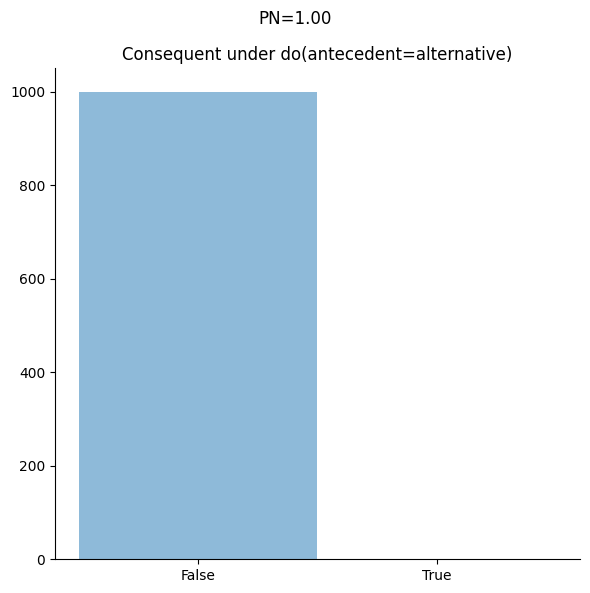

In [7]:
antecedents = {"match_dropped": torch.tensor(0.0)}
observations = {
    "match_dropped": torch.tensor(1.0),
    "lightning": torch.tensor(0.0),
    "forest_fire": torch.tensor(1.0),
}

with MultiWorldCounterfactual() as ffd_md_nol_mwc:
    with SearchForNS(
        antecedents=antecedents,
        antecedent_bias=-0.5,
        witnesses={},
        consequents=consequents,
    ):
        with condition(data=observations):
            with pyro.plate("sample", size=1000):
                with pyro.poutine.trace() as ffd_md_nol_tr:
                    ff_disjunctive()


ffd_md_nol_tr.trace.compute_log_prob()
ffd_md_nol_nd = ffd_md_nol_tr.trace.nodes

pns_plot(
    mwc=ffd_md_nol_mwc,
    nodes=ffd_md_nol_nd,
    antecedent_sites=["match_dropped"],
    outcome_site="forest_fire",
    plot_sufficiency=False,
)

This answer is correct. However, in cases of overdetermination, a similar estimation would lead us to assign no causal role to any of to co-contributing factors. This can be seen in the context in which both causes occurred. Trivially, if lightning occurred, then had no match been dropped, the forest fire would still occur (symmetric reasoning goes through for the lightning as well). This is a misdiagnosis, as we still think that these factors played a causal role.

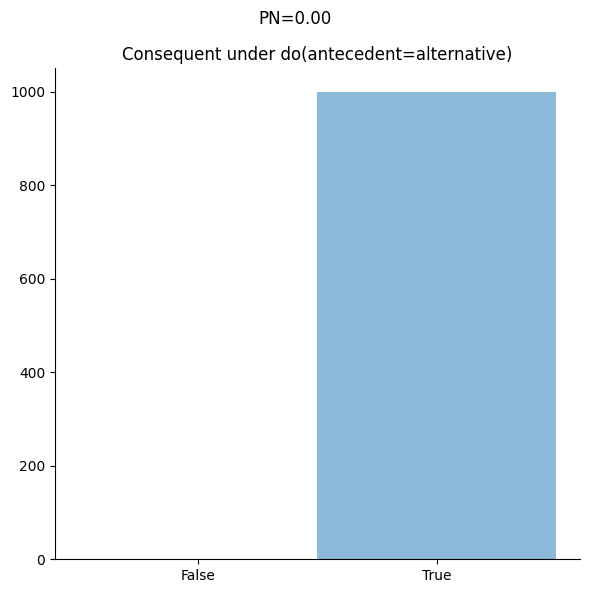

In [8]:
observations = {
    "match_dropped": torch.tensor(1.0),
    "lightning": torch.tensor(1.0),  # we changed this line
    "forest_fire": torch.tensor(1.0),
}

with MultiWorldCounterfactual() as ffd_over_mwc:
    with SearchForNS(
        antecedents=antecedents,
        antecedent_bias=-0.5,
        witnesses={},
        consequents=consequents,
        consequent_scale=1e-8,
    ):
        with condition(data=observations):
            with pyro.plate("sample", size=1000):
                with pyro.poutine.trace() as ffd_over_tr:
                    ff_disjunctive()

ffd_over_tr.trace.compute_log_prob()
ffd_over_nd = ffd_over_tr.trace.nodes

pns_plot(
    mwc=ffd_over_mwc,
    nodes=ffd_over_nd,
    antecedent_sites=["match_dropped"],
    outcome_site="forest_fire",
    plot_sufficiency=False,
)

## Witness nodes and context sensitivity

Some of these intuitions in the forest fire example may be salvaged by considering a two-membered antecedent set:

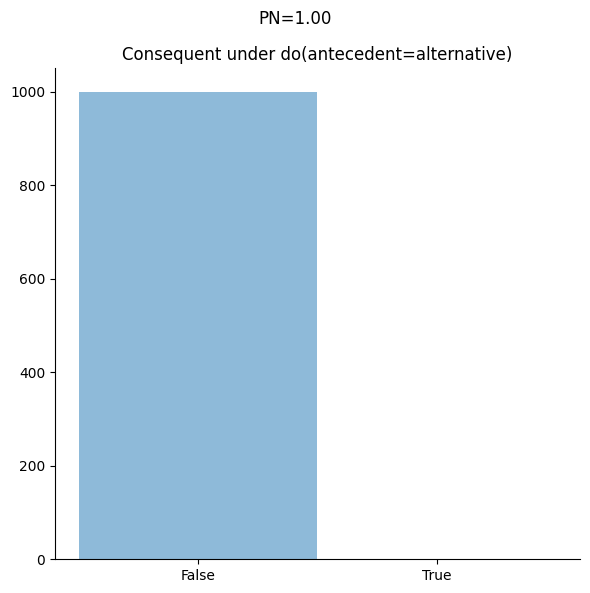

In [9]:
antecedents = {"match_dropped": 0.0, "lightning": 0.0}

with MultiWorldCounterfactual() as ffd_set_mwc:
    with SearchForNS(
        antecedents=antecedents,
        antecedent_bias=-0.5,
        witnesses={},
        consequents=consequents,
        consequent_scale=1e-8,
    ):
        with condition(data=observations):
            with pyro.plate("sample", size=1000):
                with pyro.poutine.trace() as ffd_set_tr:
                    ff_disjunctive()

ffd_set_tr.trace.compute_log_prob()
ffd_set_nd = ffd_set_tr.trace.nodes


pns_plot(
    mwc=ffd_set_mwc,
    nodes=ffd_set_nd,
    antecedent_sites=["match_dropped", "lightning"],
    outcome_site="forest_fire",
    plot_sufficiency=False,
)

This already suggests a more complicated picture, as it turns out that we need to pay attention to membership in larger antecedent sets that would make a difference (that is one reason why we need stochasticity in antecedent candidate preemption: to search for such sets).

But even then, the but-for analysis does not pay sufficient attention to the granularity of a given problem and its causal structure. There are asymmetric cases where the efficiency of one cause prevents the efficiency of another, in which our causal attributions should also be asymmetric, but "being a member of the same larger antecedent set" isn't.

A simple example is breaking a bottle. Suppose Sally and Bob throw a rock at a bottle, and Sally does so a little earlier than Bob. Suppose both are perfectly accurate, and the bottle shatters when hit. Sally hits, and the bottle shatters, but Bob doesn't hit it because the bottle is no longer there.  

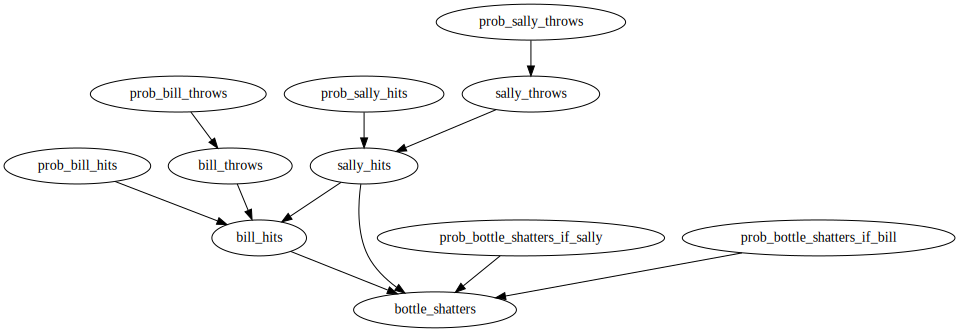

In [10]:
def stones_model():
    prob_sally_throws = pyro.sample("prob_sally_throws", dist.Beta(1, 1))
    prob_bill_throws = pyro.sample("prob_bill_throws", dist.Beta(1, 1))
    prob_sally_hits = pyro.sample("prob_sally_hits", dist.Beta(1, 1))
    prob_bill_hits = pyro.sample("prob_bill_hits", dist.Beta(1, 1))
    prob_bottle_shatters_if_sally = pyro.sample(
        "prob_bottle_shatters_if_sally", dist.Beta(1, 1)
    )
    prob_bottle_shatters_if_bill = pyro.sample(
        "prob_bottle_shatters_if_bill", dist.Beta(1, 1)
    )

    sally_throws = pyro.sample("sally_throws", dist.Bernoulli(prob_sally_throws))
    bill_throws = pyro.sample("bill_throws", dist.Bernoulli(prob_bill_throws))

    # if Sally throws, she hits with probability prob_sally_hits
    # hits with pr=0 otherwise
    new_shp = torch.where(sally_throws == 1, prob_sally_hits, 0.0)

    sally_hits = pyro.sample("sally_hits", dist.Bernoulli(new_shp))

    # if Bill throws, he hits with probability prob_bill_hits
    # if sally doesn't hit sooner,
    # misses otherwise
    new_bhp = torch.where(
        bill_throws.bool() & (~sally_hits.bool()),
        prob_bill_hits,
        torch.tensor(0.0),
    )

    bill_hits = pyro.sample("bill_hits", dist.Bernoulli(new_bhp))

    # you can use a analogous move to model the bottle shattering
    # if being hit by a stone doesn't deterministically
    # shatter the bottle
    new_bsp = torch.where(
        bill_hits.bool(),
        prob_bottle_shatters_if_bill,
        torch.where(
            sally_hits.bool(),
            prob_bottle_shatters_if_sally,
            torch.tensor(0.0),
        ),
    )

    bottle_shatters = pyro.sample("bottle_shatters", dist.Bernoulli(new_bsp))

    return {
        "sally_throws": sally_throws,
        "bill_throws": bill_throws,
        "sally_hits": sally_hits,
        "bill_hits": bill_hits,
        "bottle_shatters": bottle_shatters,
    }


stones_model.nodes = [
    "sally_throws",
    "bill_throws",
    "sally_hits",
    "bill_hits",
    "bottle_shatters",
]


pyro.render_model(stones_model)

Sally's throw does not satisfy the but-for condition: if she hadn't thrown the rock, the bottle would still have shattered. Of course, the combined event of Sally throwing a rock and Bob throwing a rock is a but-for cause of the bottle shattering. But that doesn't capture the clear asymmetry at work here. Intuitively, Sally's throw is the (actual) cause of the bottle breaking in a way that Bob's throw isn't.  Sally's throw actually caused the bottle to shatter and Bob's throw didn't, in part because Bob's stone didn't actually hit the bottle.

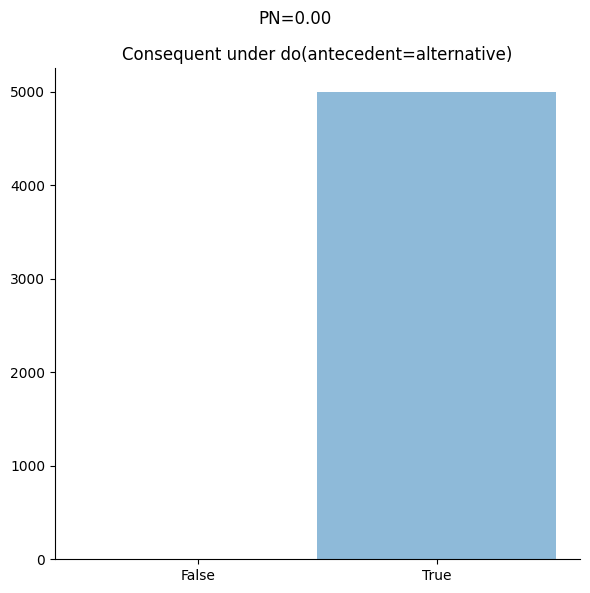

In [11]:
def tensorize_observations(observations):
    return {k: torch.as_tensor(v) for k, v in observations.items()}


# for now, we assume the mechanisms are deterministic
# and that both sally and bill throw stones
observations = {
    "prob_sally_throws": 1.0,
    "prob_bill_throws": 1.0,
    "prob_sally_hits": 1.0,
    "prob_bill_hits": 1.0,
    "prob_bottle_shatters_if_sally": 1.0,
    "prob_bottle_shatters_if_bill": 1.0,
    "sally_throws": 1.0,
    "bill_throws": 1.0,
}

observations_tensorized = tensorize_observations(observations)

antecedents = {"sally_throws": torch.tensor(0.0)}

witnesses = {}

consequents = {"bottle_shatters": constraints.boolean}

pyro.set_rng_seed(100)

with MultiWorldCounterfactual() as s_mwc:
    with SearchForNS(
        antecedents=antecedents,
        antecedent_bias=-0.5,
        witnesses=witnesses,
        consequents=consequents,
        consequent_scale=1e-8,
    ):
        with condition(data=observations_tensorized):
            with pyro.plate("sample", 5000):
                # increased sample size as we'll be estimating probabilities soon
                with pyro.poutine.trace() as s_tr:
                    stones_model()

s_tr.trace.compute_log_prob()
s_nd = s_tr.trace.nodes

pns_plot(
    mwc=s_mwc,
    nodes=s_nd,
    antecedent_sites=["sally_throws"],
    outcome_site="bottle_shatters",
    plot_sufficiency=False,
)

An intuitive solution to the problem, inspired by the  Pearl-Halpern definition of actual causality (which we discuss in [another notebook](https://basisresearch.github.io/chirho/actual_causality.html)) is to say that **in answering actual causality queries, we need to consider what happens when part of the actual context is kept fixed.** For instance, in the bottle shattering example, given the observed fact that Bob’s stone didn’t hit, in the counterfactual world in which we keep this observed fact fixed, if Sally nad not thrown the stone, the bottle in fact would not have shattered. 


For this reason, our handler allows not only stochastic preemption of interventions (to approximate the search through possible antecedent sets) but also stochastic witness preemption of those nodes that are considered part of the context (these needn't exclude each other). In a witness preemption, we ensure that the counterfactual value is identical to the factual one (and by applying it randomly to candidate witness nodes, we approximate a search through all possible context sets).

One question you might be interested is whether **given some additional claims true for this particular case**, if the input nodes had a different value, so would the outcome. That is, you might be interested in the following query:

**Is there some context such that if it is kept fixed at the factual values, if the antecedent were different, so would be the consequent?**

This is a simplified question in line with the original Halpern-Pearl definition - take a look at [a separate notebook](https://basisresearch.github.io/chirho/actual_causality.html), if you're interested in the details of the original definition.

In our case, we might want to know whether there are some nodes that kept fixed at their actual value would make a context-restricted but-for clause true (intuitively: keeping the fact that bill failed fixed, if Sally didn't throw the stone, the bottle wouldn't have shattered). 

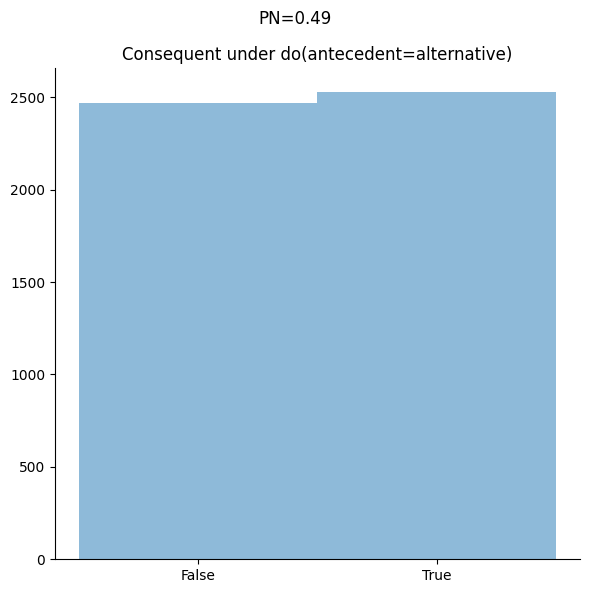

In [12]:
# this now specifies the nodes that are candidates for witnesses
# i.e. those parts of context that are held fixed in a given run
# in the counterfactual world
witnesses = {
    "bill_hits": constraints.boolean,
}

with MultiWorldCounterfactual() as sw_mwc:
    with SearchForNS(
        antecedents=antecedents,
        antecedent_bias=-0.5,
        witnesses=witnesses,
        consequents=consequents,
        consequent_scale=1e-8,
    ):
        with condition(data=observations_tensorized):
            with pyro.plate("sample", 5000):
                # increased sample size as we'll be estimating probabilities soon
                with pyro.poutine.trace() as sw_tr:
                    stones_model()

sw_tr.trace.compute_log_prob()
sw_nd = sw_tr.trace.nodes

pns_plot(
    mwc=sw_mwc,
    nodes=sw_nd,
    antecedent_sites=["sally_throws"],
    outcome_site="bottle_shatters",
    plot_sufficiency=False,
)

In the above, we sample potential witness sets, and there is only one of them. The probability of its being fixed at the actual value is 0.5, and in that context, changing the value of the antecedent would have made a difference, which is mirrored in our posterior counterfactual distribution estimate also being close to 0.5.

## Probability of causation and responsibility

We might use non-trivial probabilities and be interested in more involved queries. Suppose we aren't sure what part of the context we want to hold fixed, so we attach equal weights to all possible context sets. What's our expectation when it comes to whether changing the input would change the outcome assuming these changes aren't preempted downstream? Or, in our terminology, what's the probability of a context-sensitive but-for clause holding?

**Assuming each witness candidate is equally likely to be considered part of a context and we observed such and such outcome, what's the probability that the antecedent having a different value would lead to a different outcome if no node on the path from the antecedent to the consequent is held fixed as part of the context?**

In [13]:
observations = {
    "prob_sally_throws": 0.6,
    "prob_bill_throws": 0.4,
    "prob_sally_hits": 0.9,
    "prob_bill_hits": 0.8,
    "prob_bottle_shatters_if_sally": 0.9,
    "prob_bottle_shatters_if_bill": 0.8,
    "bottle_shatters": 1.0,
}

observations_tensorized = tensorize_observations(observations)


# note that now we don't specify what the alternative interventions are,
# they are samples from uniform(constraint)
antecedents = {"sally_throws": constraints.boolean, "bill_throws": constraints.boolean}

# we never need to specify what values the witness nodes
# are supposed to have, as these are always the factual values
# we just need to specify the constraints
witnesses = {"sally_hits": constraints.boolean, "bill_hits": constraints.boolean}

# witnesses and antecedents now overlap
# if they both happen to be preempted,
# witness preemption wins and the
# counterfactual values are identical to the factual ones

# it's also ok to not specify what value the consequent is supposed to have
consequents = {"bottle_shatters": constraints.boolean}


with MultiWorldCounterfactual() as s2_mwc_prob:
    with SearchForNS(
        antecedents=antecedents,
        witnesses=witnesses,
        consequents=consequents,
        consequent_scale=1e-8,
    ):
        with condition(data=observations_tensorized):
            with pyro.plate("sample", 100000):
                with pyro.poutine.trace() as s2_tr_prob:
                    stones_model()

s2_tr_prob.trace.compute_log_prob()
s2_nd_prob = s2_tr_prob.trace.nodes

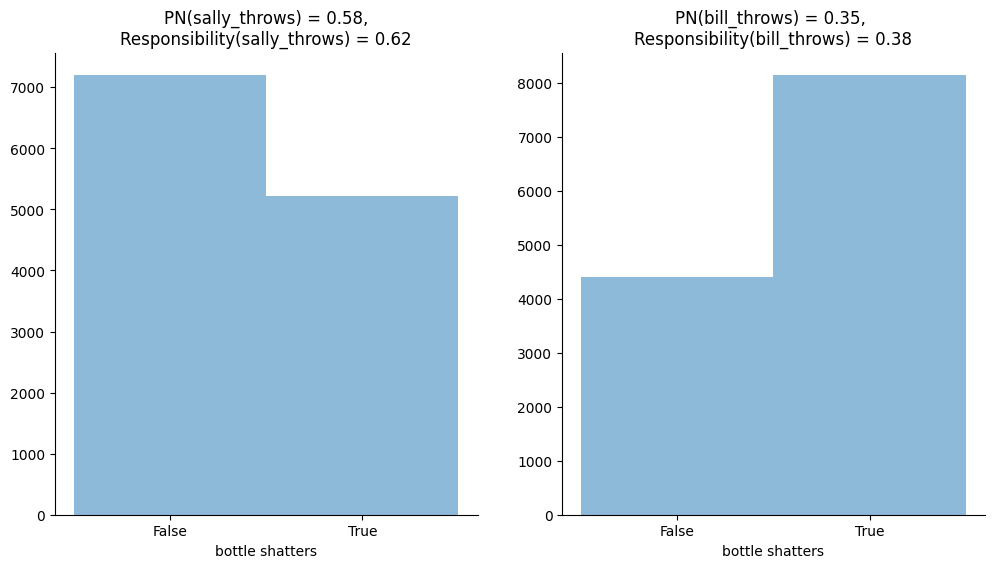

In [14]:
with s2_mwc_prob:
    st_observed = gather(
        s2_nd_prob["sally_throws"]["value"], IndexSet(sally_throws={0}, bill_throws={0})
    ).flatten()
    st_necessity = gather(
        s2_nd_prob["sally_throws"]["value"], IndexSet(sally_throws={1}, bill_throws={1})
    ).flatten()
    sh_preempted = s2_nd_prob["__witness_sally_hits"]["value"]

    bt_observed = gather(
        s2_nd_prob["bill_throws"]["value"], IndexSet(sally_throws={0}, bill_throws={0})
    ).flatten()

    bt_necessity = gather(
        s2_nd_prob["bill_throws"]["value"], IndexSet(sally_throws={1}, bill_throws={1})
    ).flatten()

    bh_preempted = s2_nd_prob["__witness_bill_hits"]["value"]

    bottle_shatters_nec = gather(
        s2_nd_prob["bottle_shatters"]["value"],
        IndexSet(sally_throws={1}, bill_throws={1}),
    ).flatten()


sally_throws_mask = (st_observed != st_necessity) * (1 - sh_preempted).bool()
bill_throws_mask = (bt_observed != bt_necessity) * (1 - bh_preempted).bool()


bottle_sally_nec = bottle_shatters_nec[sally_throws_mask]
bottle_bill_nec = bottle_shatters_nec[bill_throws_mask]


pn_st = torch.mean(1 - bottle_sally_nec)
pn_bt = torch.mean(1 - bottle_bill_nec)

resp_st = pn_st / (pn_st + pn_bt)
resp_bt = pn_bt / (pn_st + pn_bt)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.hist(bottle_sally_nec, bins=[-0.5, 0.5, 1.5], alpha=0.5)
ax1.set_title(
    f"PN(sally_throws) = {pn_st:.2f},\nResponsibility(sally_throws) = {resp_st:.2f}"
)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(["False", "True"])
ax1.set_xlabel("bottle shatters")


ax2.hist(bottle_bill_nec, bins=[-0.5, 0.5, 1.5], alpha=0.5)
ax2.set_title(
    f"PN(bill_throws) = {pn_bt:.2f}, \nResponsibility(bill_throws) = {resp_bt:.2f}"
)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(["False", "True"])
ax2.set_xlabel("bottle shatters")

sns.despine()
plt.show()